# A Simulation Study for Time-varying coefficients

In [1]:
import math
from math import pi
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist

# from orbit.estimators.pyro_estimator import PyroEstimatorVI
# from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

from orbit.utils.plot import get_orbit_style
orbit_style = get_orbit_style()
plt.style.use(orbit_style)

%load_ext autoreload
%autoreload 2

# Data Simulation Modules

In [2]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
#         'x1': stats.chi2.rvs(4, size=n),
#         'x2': stats.t.rvs(2, size=n),
#         'x3': stats.t.rvs(2, size=n),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [3]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.001,2018-01-01,0.002,1.016283,0.010079,-4.112205,6.235252,8.318071,1.000000,-0.772024,5.640371
1,0.002,2018-01-02,0.004,1.022566,0.010316,-0.499279,-14.816010,3.641032,1.075149,1.243571,-13.871215
2,0.003,2018-01-03,0.006,1.028848,0.010711,1.826034,-2.897783,-17.144133,1.278494,-0.352154,-3.506200
3,0.004,2018-01-04,0.008,1.035130,0.011263,24.874740,5.439502,6.055187,1.104741,-0.571943,5.325848
4,0.005,2018-01-05,0.010,1.041411,0.011973,1.734577,-16.383980,9.075009,1.059079,-0.218024,-17.154473
5,0.006,2018-01-06,0.012,1.047690,0.012841,-11.059695,12.494699,2.577940,1.088198,0.541397,13.532358
6,0.007,2018-01-07,0.014,1.053968,0.013866,-6.065916,4.606459,-9.182241,1.153368,0.474600,5.117413
7,0.008,2018-01-08,0.016,1.060244,0.015049,0.945238,3.450288,13.376691,1.244678,2.122431,5.997009
8,0.009,2018-01-09,0.018,1.066519,0.016389,11.628231,11.262647,16.722551,1.167512,0.439053,12.934243
9,0.010,2018-01-10,0.020,1.072791,0.017885,2.740874,2.271040,-17.405263,1.352738,0.496264,2.676133


In [4]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.118687,12.579436,-18.705481,0.083833,0.118039,0.106882,4.238243,2018-01-01
1,0.251493,5.300673,8.974563,0.081579,0.116649,0.116075,6.762299,2018-01-02
2,-12.535904,2.134341,4.224095,0.083838,0.112736,0.121694,4.576347,2018-01-03
3,-6.830381,3.094571,-1.926185,0.067788,0.111347,0.126284,4.497561,2018-01-04
4,-3.370150,3.899625,-3.083105,0.086333,0.099882,0.138985,5.230371,2018-01-05
5,-3.364463,-4.186151,13.149254,0.076195,0.108590,0.142555,6.102766,2018-01-06
6,-3.663559,-14.795409,-1.731279,0.091534,0.099006,0.156208,3.284992,2018-01-07
7,7.205991,-5.623366,-11.806551,0.100954,0.099507,0.160083,2.529016,2018-01-08
8,-3.643661,3.799626,-1.398166,0.100640,0.087954,0.163894,4.908982,2018-01-09
9,9.222329,1.695171,-0.896493,0.098496,0.085971,0.172410,5.529784,2018-01-10


## Test on how knots and segements interact

In [5]:
from orbit.utils.knots import get_knot_idx_by_dist, get_knot_idx, get_knot_dates

In [6]:
knot_idx = get_knot_idx(num_of_obs=400, num_of_segments=10)
knot_idx

array([  0,  40,  80, 120, 160, 200, 239, 279, 319, 359, 399])

In [7]:
knot_idx = get_knot_idx(num_of_obs=250, knot_distance=10)
knot_idx

array([  0,   9,  19,  29,  39,  49,  59,  69,  79,  89,  99, 109, 119,
       129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249])

In [8]:
date_array = rw_data['date'].values
date_array.dtype

dtype('<M8[ns]')

In [9]:
date_array[:5]

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
knot_dates=['2018-01-01','2018-07-01','2018-09-09']
knot_dates = np.array(knot_dates, dtype='datetime64')
knot_dates[:5]

array(['2018-01-01', '2018-07-01', '2018-09-09'], dtype='datetime64[D]')

In [11]:
knot_idx = get_knot_idx(date_array=date_array, knot_dates=knot_dates)
knot_idx

Index([0, 181, 251], dtype='int64')

In [12]:
infer_freq = pd.infer_freq(date_array)

In [13]:
knot_idx * np.timedelta64(1, infer_freq)  + date_array[0]

DatetimeIndex(['2018-01-01', '2018-07-01', '2018-09-09'], dtype='datetime64[ns]', freq=None)

In [14]:
get_knot_dates(date_array[0], knot_idx, infer_freq)

DatetimeIndex(['2018-01-01', '2018-07-01', '2018-09-09'], dtype='datetime64[ns]', freq=None)

# Random Walk Coefficients Simulation Study

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [15]:
from orbit.models import KTR

In [16]:
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]

In [17]:
ktrx_neutral = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=0.1,
    
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
)

In [18]:
ktrx_neutral.fit(df=rw_data)  

2024-01-21 17:24:16 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 17:24:16 - orbit - INFO - Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
2024-01-21 17:24:16 - orbit - INFO - step    0 loss = 1529.1, scale = 0.10131
INFO:orbit:step    0 loss = 1529.1, scale = 0.10131
2024-01-21 17:24:16 - orbit - INFO - step   50 loss = 384.48, scale = 0.052799
INFO:orbit:step   50 loss = 384.48, scale = 0.052799
2024-01-21 17:24:17 - orbit - INFO - step  100 loss = 332.66, scale = 0.056398
INFO:orbit:step

In [19]:
idx = 3

In [20]:
from orbit.constants.palette import PredictionPaletteClassic as PredPal

In [21]:
PredPal.PREDICTION_LINE.value

'#276EF1'

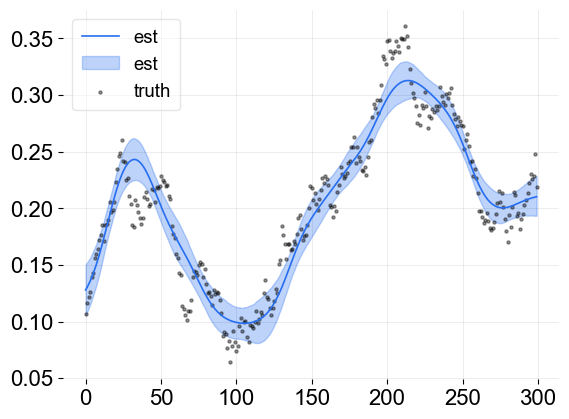

In [22]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=5, alpha=0.4, color=PredPal.ACTUAL_OBS.value)
plt.legend();

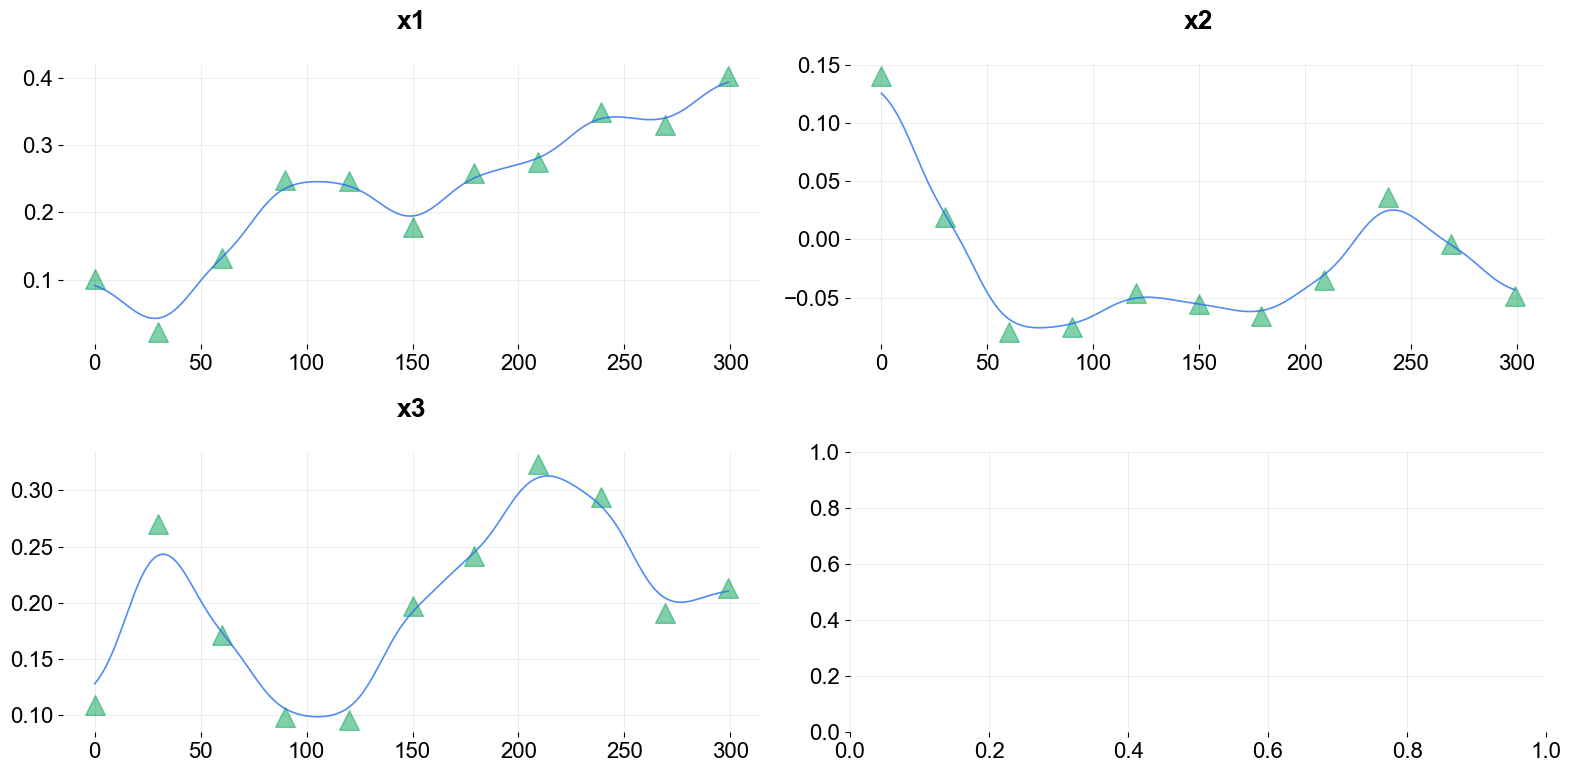

In [23]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [24]:
ktrx_pos = KTR(
    response_col='y',
    date_col='date',

    level_knot_scale=0.1,
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
)

In [25]:
ktrx_pos.fit(df=rw_data) 

2024-01-21 17:24:22 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 17:24:22 - orbit - INFO - Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
2024-01-21 17:24:22 - orbit - INFO - step    0 loss = 2305.6, scale = 0.10649
INFO:orbit:step    0 loss = 2305.6, scale = 0.10649
2024-01-21 17:24:23 - orbit - INFO - step   50 loss = 442.26, scale = 0.27467
INFO:orbit:step   50 loss = 442.26, scale = 0.27467
2024-01-21 17:24:23 - orbit - INFO - step  100 loss = 404.1, scale = 0.44794
INFO:orbit:step  100 loss = 404.1, scale = 0.44794
2024-01-21 17:24:23 - orbit - INFO - step  150 loss = 402.01, scale = 0.46575
INFO:orbit:step  150 loss = 402.01, scale = 0.46575
2024-01-21 17:24:24 - orbit - INFO - step  200 loss 

In [26]:
idx = 3

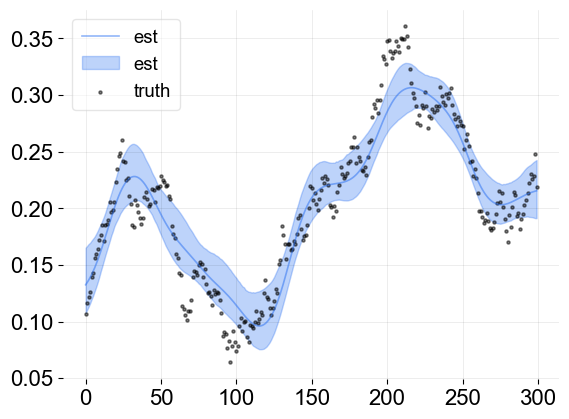

In [27]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5, color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', 
                 alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=5, alpha=0.5, color=PredPal.ACTUAL_OBS.value)
plt.legend();

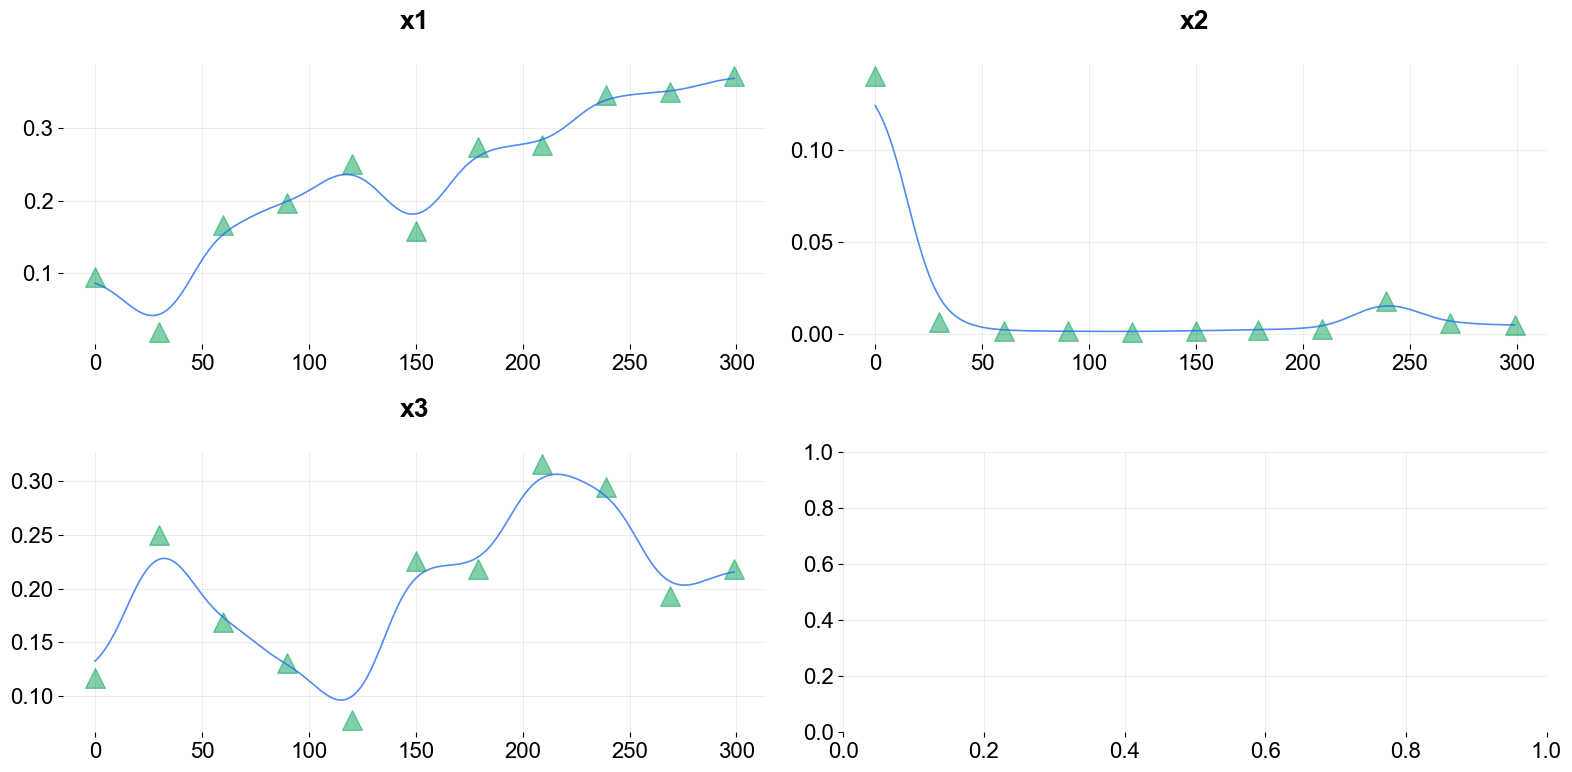

In [28]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

# Sine - Cosine Coefficients Simulation Study

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [29]:
p = 3
# define independent and response variables
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]

In [30]:
%%time
ktrx_neutral = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=.1,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
 
    flat_multiplier=True,
)

ktrx_neutral.fit(df=seas_data)                                  

2024-01-21 17:24:26 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 17:24:27 - orbit - INFO - Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
2024-01-21 17:24:27 - orbit - INFO - step    0 loss = 9426.8, scale = 0.12361
INFO:orbit:step    0 loss = 9426.8, scale = 0.12361
2024-01-21 17:24:27 - orbit - INFO - step   50 loss = 4039.9, scale = 0.30712
INFO:orbit:step   50 loss = 4039.9, scale = 0.30712
2024-01-21 17:24:28 - orbit - INFO - step  100 loss = 3901.3, scale = 0.34743
INFO:orbit:step  100 loss = 3901.3, scale = 0.34743
2024-01-21 17:24:28 - orbit - INFO - step  150 loss = 2484.2, scale = 0.18519
INFO:orbit:step  150 loss = 2484.2, scale = 0.18519
2024-01-21 17:24:29 - orbit - INFO - step  200 los

CPU times: user 9.51 s, sys: 2.64 s, total: 12.1 s
Wall time: 6.27 s


In [31]:
idx = 3

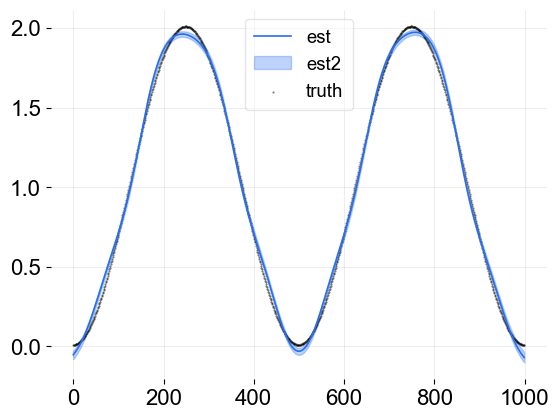

In [32]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est2',
                 alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=0.3, alpha=0.5,
            color = PredPal.ACTUAL_OBS.value)
plt.legend();

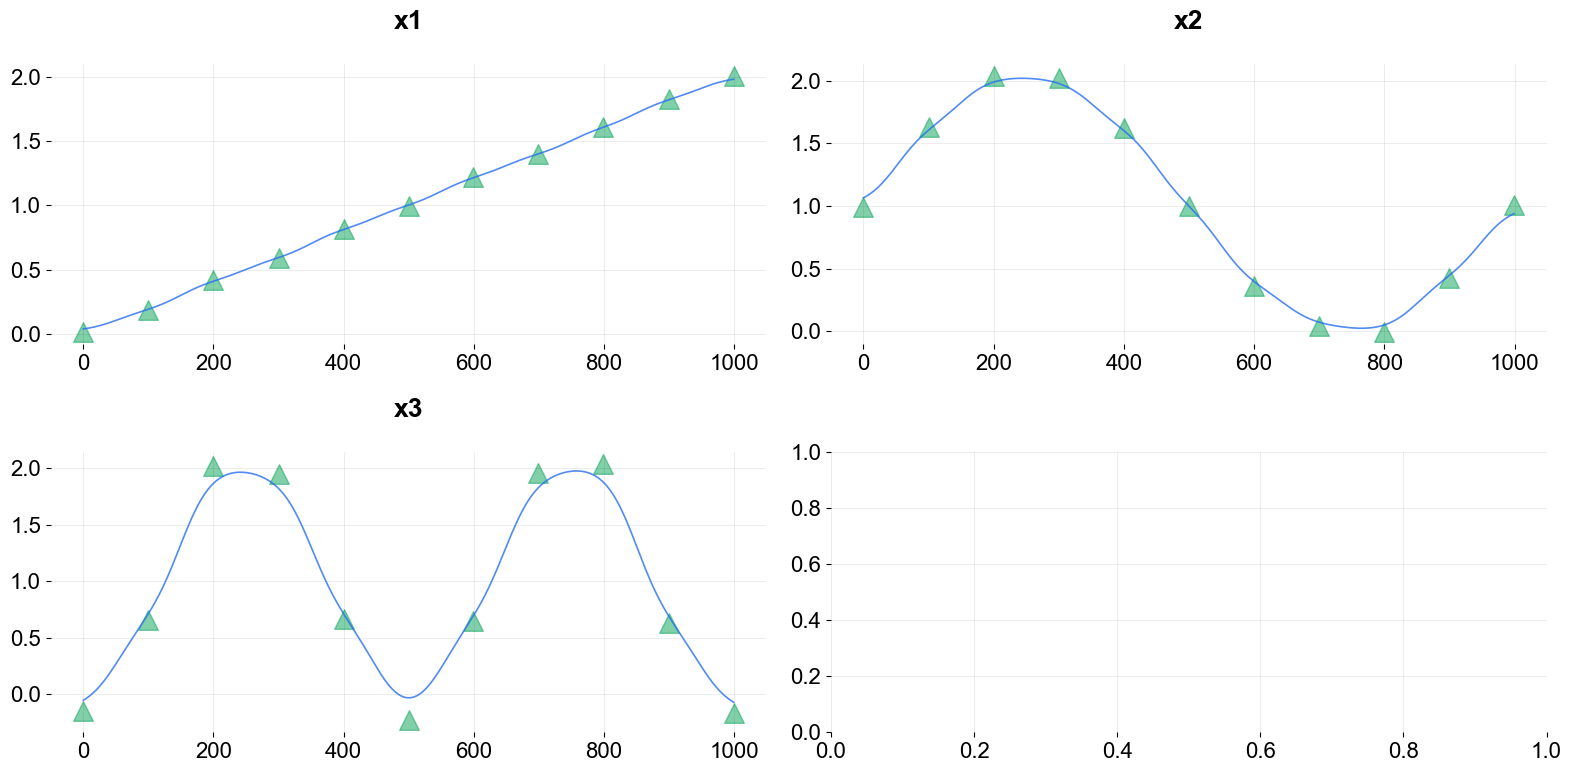

In [33]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [34]:
%%time
ktrx_pos = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=.1,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
 
    flat_multiplier=True,
)

ktrx_pos.fit(df=seas_data)                                  

2024-01-21 17:24:33 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 17:24:34 - orbit - INFO - Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 501, samples: 1000, learning rate: 0.2, learning_rate_total_decay: 0.05 and particles: 100.
2024-01-21 17:24:34 - orbit - INFO - step    0 loss = 14607, scale = 0.090058
INFO:orbit:step    0 loss = 14607, scale = 0.090058
2024-01-21 17:24:34 - orbit - INFO - step   50 loss = 2421, scale = 0.24169
INFO:orbit:step   50 loss = 2421, scale = 0.24169
2024-01-21 17:24:35 - orbit - INFO - step  100 loss = 1910.1, scale = 0.34806
INFO:orbit:step  100 loss = 1910.1, scale = 0.34806
2024-01-21 17:24:35 - orbit - INFO - step  150 loss = 1892.5, scale = 0.32626
INFO:orbit:step  150 loss = 1892.5, scale = 0.32626
2024-01-21 17:24:36 - orbit - INFO - step  200 loss = 

CPU times: user 9.4 s, sys: 2.62 s, total: 12 s
Wall time: 6.16 s


In [35]:
idx = 3

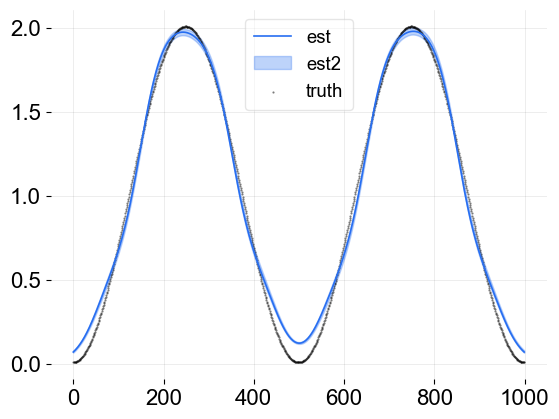

In [36]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est2',
                 alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=0.3, alpha=0.5,
            color = PredPal.ACTUAL_OBS.value)
plt.legend();

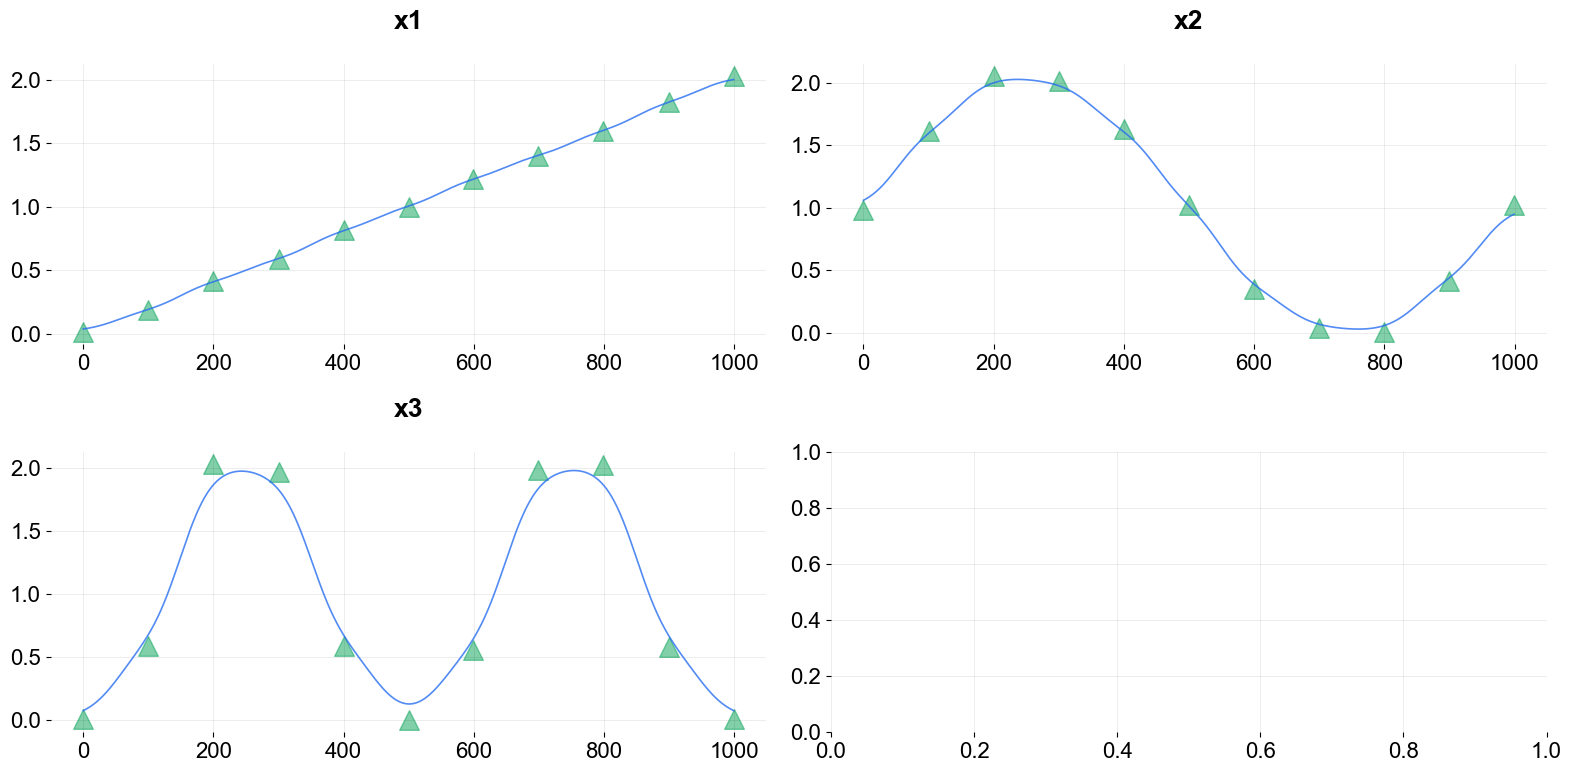

In [37]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))